In [1]:
import torch
import torch.utils.data
from torch import nn
from torch.nn import functional as F

from ignite.engine import Events, Engine
from ignite.metrics import Accuracy, Loss

import numpy as np
import sklearn.datasets

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [2]:
noise = 0.1
X_train, y_train = sklearn.datasets.make_moons(n_samples=1500, noise=noise)
X_test, y_test = sklearn.datasets.make_moons(n_samples=200, noise=noise)
ds_train = torch.utils.data.TensorDataset(torch.from_numpy(X_train).float(), F.one_hot(torch.from_numpy(y_train)).float())
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=64, shuffle=True, drop_last=True)

In [3]:
class Model_bilinear(nn.Module):
    def __init__(self, features, num_embeddings):
        super().__init__()
        
        self.gamma = 0.99
        self.sigma = 0.3
        
        embedding_size = 10
        
        self.fc1 = nn.Linear(2, features)
        self.fc2 = nn.Linear(features, features)
        self.fc3 = nn.Linear(features, features)
        
        self.W = nn.Parameter(torch.normal(torch.zeros(embedding_size, num_embeddings, features), 1))
        
        self.register_buffer('N', torch.ones(num_embeddings) * 20)
        self.register_buffer('m', torch.normal(torch.zeros(embedding_size, num_embeddings), 1))
        
        self.m = self.m * self.N.unsqueeze(0)

    def embed(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        # i is batch, m is embedding_size, n is num_embeddings (classes)
        x = torch.einsum('ij,mnj->imn', x, self.W)
        
        return x

    def bilinear(self, z):
        embeddings = self.m / self.N.unsqueeze(0)
        
        diff = z - embeddings.unsqueeze(0)            
        y_pred = (- diff**2).mean(1).div(2 * self.sigma**2).exp()
        
        return y_pred, embeddings

    def forward(self, x):
        z = self.embed(x)
        y_pred, embeddings = self.bilinear(z)
        
        return z, y_pred, embeddings

    def update_embeddings(self, x, y):
        z = self.embed(x)
        
        # normalizing value per class, assumes y is one_hot encoded
        self.N = torch.max(self.gamma * self.N + (1 - self.gamma) * y.sum(0), torch.ones_like(self.N))
        
        # compute sum of embeddings on class by class basis
        features_sum = torch.einsum('ijk,ik->jk', z, y)
        
        self.m = self.gamma * self.m + (1 - self.gamma) * features_sum
        
model = Model_bilinear(20, 2)
for name, param in model.named_buffers():
    print(name)
print("-----------")
for name, param in model.named_parameters():
    print(name)
print('--------')
state_dict = model.state_dict()
for name, value in state_dict.items():
    print(name)
print(model.N.shape)
print(model.m.shape)
print(model.W.shape)


print(model.N)
print('------------------------------------')
print(model.m)
print('------------------------------------')
print(model.W)

N
m
-----------
W
fc1.weight
fc1.bias
fc2.weight
fc2.bias
fc3.weight
fc3.bias
--------
W
N
m
fc1.weight
fc1.bias
fc2.weight
fc2.bias
fc3.weight
fc3.bias
torch.Size([2])
torch.Size([10, 2])
torch.Size([10, 2, 20])
tensor([20., 20.])
------------------------------------
tensor([[-10.3408,  -5.0763],
        [ -1.1817,  13.9887],
        [-54.1310, -10.4176],
        [-23.2820,  -2.1833],
        [-28.3928,  29.7887],
        [ 17.3332,  27.3302],
        [-16.1729,  41.6898],
        [ -7.7534,  28.5859],
        [  1.3801,   9.2125],
        [ -3.5683,  -7.6297]])
------------------------------------
Parameter containing:
tensor([[[-1.6866,  0.5092, -0.3829,  0.3420, -0.6759,  0.4166,  0.6985,
           0.2637, -0.4887,  0.2715,  0.1709,  0.7638,  1.2042, -0.0925,
           0.7994,  1.3660,  0.8616,  0.4300,  1.3734, -0.3928],
         [ 1.9823, -0.9277,  0.0406,  0.7007, -1.2576, -1.6304,  0.6036,
           0.8745, -0.1667, -0.6402,  0.3716, -0.9453,  0.5634, -0.3728,
          -0.2

tensor([[[-0.7225,  0.9667],
         [ 0.7180,  1.6416],
         [-1.1908,  1.2073],
         [-0.9462, -0.5033],
         [-0.1794, -0.7391],
         [-0.6341, -1.5219],
         [-1.1865, -0.5404],
         [-0.0956,  0.5957],
         [-0.0263,  0.4852],
         [ 0.2180, -1.3044]]], grad_fn=<ViewBackward0>) tensor([[1.8564e-02, 2.6381e-07]], grad_fn=<ExpBackward0>) tensor([[-0.5170, -0.2538],
        [-0.0591,  0.6994],
        [-2.7065, -0.5209],
        [-1.1641, -0.1092],
        [-1.4196,  1.4894],
        [ 0.8667,  1.3665],
        [-0.8086,  2.0845],
        [-0.3877,  1.4293],
        [ 0.0690,  0.4606],
        [-0.1784, -0.3815]])


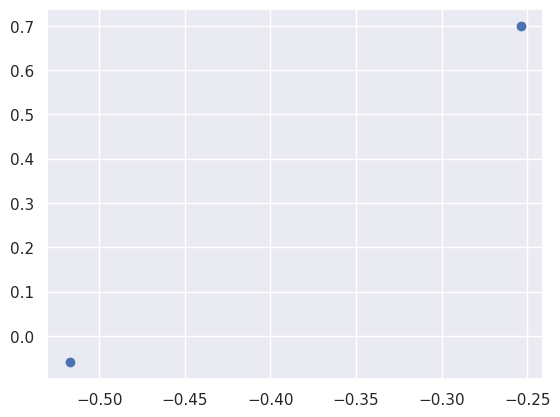

In [4]:
import matplotlib.pyplot as plt
emb = (model.m / model.N.unsqueeze(0)).numpy()
plt.scatter(emb[0], emb[1])

inp = torch.tensor([[-2.0, 0]])
x,y,z = model(inp)
print(x,y,z)

In [5]:
import copy
from torch.quantization import quantize_fx

quantise = True
if quantise:
    dataiter = iter(dl_train)
    images, labels = next(dataiter)

    m = copy.deepcopy(model)
    m.to("cpu")
    m.eval()
    qconfig_dict = {"": torch.quantization.get_default_qconfig("fbgemm")}
    model_prepared = quantize_fx.prepare_fx(m, qconfig_dict, images)

    with torch.inference_mode():
        for _ in range(10):
            images, labels = next(dataiter)
            model_prepared(images)
    model_quantized = quantize_fx.convert_fx(model_prepared)
    
for name, param in model_quantized.named_buffers():
    print(name)
print('--------')
for name, param in model_quantized.named_parameters():
    print(name)
print("-----------")
state_dict = model_quantized.state_dict()
for name, value in state_dict.items():
    print(name)
print(model_quantized._tensor_constant0.shape)
print(model_quantized._tensor_constant1.shape)
print(model_quantized.W.shape)

print(model_quantized._tensor_constant0)
print('------------------------------------')
print(model_quantized._tensor_constant1)
print('------------------------------------')
print(model_quantized.W)

fc1_input_scale_0
fc1_input_zero_point_0
_tensor_constant0
_scale_0
_zero_point_0
_tensor_constant1
--------
W
-----------
W
fc1_input_scale_0
fc1_input_zero_point_0
_tensor_constant0
_scale_0
_zero_point_0
_tensor_constant1
fc1.scale
fc1.zero_point
fc1._packed_params.dtype
fc1._packed_params._packed_params
fc2.scale
fc2.zero_point
fc2._packed_params.dtype
fc2._packed_params._packed_params
fc3.scale
fc3.zero_point
fc3._packed_params.dtype
fc3._packed_params._packed_params
torch.Size([1, 10, 2])
torch.Size([10, 2])
torch.Size([10, 2, 20])
tensor([[[-0.5170, -0.2538],
         [-0.0591,  0.6994],
         [-2.7065, -0.5209],
         [-1.1641, -0.1092],
         [-1.4196,  1.4894],
         [ 0.8667,  1.3665],
         [-0.8086,  2.0845],
         [-0.3877,  1.4293],
         [ 0.0690,  0.4606],
         [-0.1784, -0.3815]]])
------------------------------------
tensor([[-0.5170, -0.2538],
        [-0.0591,  0.6994],
        [-2.7065, -0.5209],
        [-1.1641, -0.1092],
        [-1.419

/opt/conda/lib/python3.10/site-packages/torch/ao/quantization/fx/prepare.py:1530: UserWarning: Passing a QConfig dictionary to prepare is deprecated and will not be supported in a future version. Please pass in a QConfigMapping instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/ao/quantization/observer.py:214: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


tensor([[[-0.8277,  0.8421],
         [ 0.4909,  1.4354],
         [-0.9230,  0.8701],
         [-0.8065, -0.6012],
         [-0.2504, -0.3833],
         [-0.4741, -1.3405],
         [-1.0689, -0.5755],
         [ 0.0219,  0.5331],
         [-0.0080,  0.4559],
         [ 0.1869, -1.0239]]], grad_fn=<ViewBackward0>) tensor([[1.9547e-02, 2.7925e-06]]) tensor([[-0.5170, -0.2538],
        [-0.0591,  0.6994],
        [-2.7065, -0.5209],
        [-1.1641, -0.1092],
        [-1.4196,  1.4894],
        [ 0.8667,  1.3665],
        [-0.8086,  2.0845],
        [-0.3877,  1.4293],
        [ 0.0690,  0.4606],
        [-0.1784, -0.3815]])


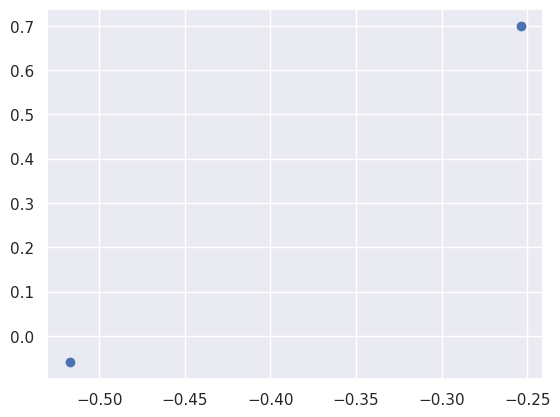

In [6]:
import matplotlib.pyplot as plt
emb = (model_quantized._tensor_constant1).numpy()
plt.scatter(emb[0], emb[1])


inpu = torch.tensor([[-2.0, 0]])
x,y,z = model_quantized(inpu)
print(x,y,z)

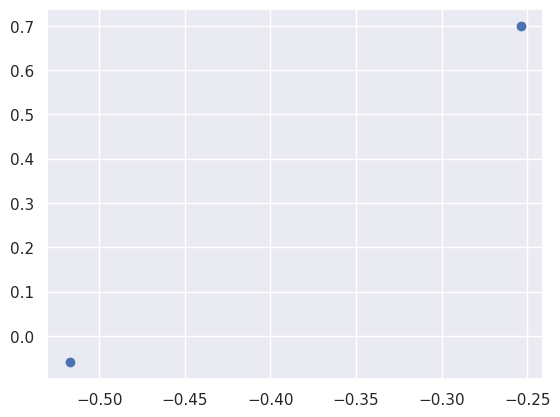

In [7]:
dataiter = iter(dl_train)
x, y = next(dataiter)
z, y_pred, embeddings = model(x)

emb = (model.m / model.N.unsqueeze(0)).detach().numpy()
plt.scatter(emb[0], emb[1])

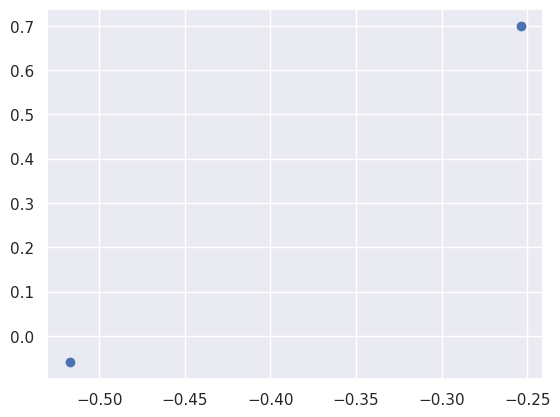

In [8]:
dataiter = iter(dl_train)
x, y = next(dataiter)
z, y_pred, embeddings = model_quantized(x)

emb = (model_quantized._tensor_constant1).numpy()
plt.scatter(emb[0], emb[1])

In [9]:
np.random.seed(0)
torch.manual_seed(0)

l_gradient_penalty = 1.0

# Moons
noise = 0.1
X_train, y_train = sklearn.datasets.make_moons(n_samples=1500, noise=noise)
X_test, y_test = sklearn.datasets.make_moons(n_samples=200, noise=noise)

num_classes = 2
batch_size = 64

model = Model_bilinear(20, num_classes)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)


def calc_gradient_penalty(x, y_pred):
    gradients = torch.autograd.grad(
            outputs=y_pred,
            inputs=x,
            grad_outputs=torch.ones_like(y_pred),
            create_graph=True,
        )[0]


    gradients = gradients.flatten(start_dim=1)
    
    # L2 norm
    grad_norm = gradients.norm(2, dim=1)

    # Two sided penalty
    gradient_penalty = ((grad_norm - 1) ** 2).mean()
    
    # One sided penalty - down
#     gradient_penalty = F.relu(grad_norm - 1).mean()

    return gradient_penalty


def output_transform_acc(output):
    y_pred, y, x, z = output
    
    y = torch.argmax(y, dim=1)
        
    return y_pred, y


def output_transform_bce(output):
    y_pred, y, x, z = output

    return y_pred, y


def output_transform_gp(output):
    y_pred, y, x, z = output

    return x, y_pred


def step(engine, batch):
    model.train()
    optimizer.zero_grad()
    
    x, y = batch
    x.requires_grad_(True)
    
    z, y_pred, embeddings = model(x)
    
    loss1 =  F.binary_cross_entropy(y_pred, y)
    loss2 = l_gradient_penalty * calc_gradient_penalty(x, y_pred)
    
    loss = loss1 + loss2
    
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        model.update_embeddings(x, y)
    
    return loss.item()


def eval_step(engine, batch):
    model.eval()

    x, y = batch

    x.requires_grad_(True)

    z, y_pred, embeddings = model(x)

    return y_pred, y, x, z
    

trainer = Engine(step)
evaluator = Engine(eval_step)

metric = Accuracy(output_transform=output_transform_acc)
metric.attach(evaluator, "accuracy")

metric = Loss(F.binary_cross_entropy, output_transform=output_transform_bce)
metric.attach(evaluator, "bce")

metric = Loss(calc_gradient_penalty, output_transform=output_transform_gp)
metric.attach(evaluator, "gp")


ds_train = torch.utils.data.TensorDataset(torch.from_numpy(X_train).float(), F.one_hot(torch.from_numpy(y_train)).float())
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=batch_size, shuffle=True, drop_last=True)

ds_test = torch.utils.data.TensorDataset(torch.from_numpy(X_test).float(), F.one_hot(torch.from_numpy(y_test)).float())
dl_test = torch.utils.data.DataLoader(ds_test, batch_size=200, shuffle=False)

@trainer.on(Events.EPOCH_COMPLETED)
def log_results(trainer):
    evaluator.run(dl_test)
    metrics = evaluator.state.metrics

    print("Test Results - Epoch: {} Acc: {:.4f} BCE: {:.2f} GP {:.2f}"
          .format(trainer.state.epoch, metrics['accuracy'], metrics['bce'], metrics['gp']))

In [10]:
trainer.run(dl_train, max_epochs=30)

Test Results - Epoch: 1 Acc: 0.8350 BCE: 0.47 GP 0.21
Test Results - Epoch: 2 Acc: 0.8750 BCE: 0.36 GP 0.12
Test Results - Epoch: 3 Acc: 0.9100 BCE: 0.29 GP 0.06
Test Results - Epoch: 4 Acc: 0.9400 BCE: 0.25 GP 0.05
Test Results - Epoch: 5 Acc: 0.9700 BCE: 0.18 GP 0.09
Test Results - Epoch: 6 Acc: 0.9750 BCE: 0.15 GP 0.06
Test Results - Epoch: 7 Acc: 0.9800 BCE: 0.14 GP 0.04
Test Results - Epoch: 8 Acc: 0.9900 BCE: 0.11 GP 0.06
Test Results - Epoch: 9 Acc: 0.9950 BCE: 0.11 GP 0.04
Test Results - Epoch: 10 Acc: 0.9950 BCE: 0.11 GP 0.04
Test Results - Epoch: 11 Acc: 0.9950 BCE: 0.10 GP 0.03
Test Results - Epoch: 12 Acc: 1.0000 BCE: 0.09 GP 0.04
Test Results - Epoch: 13 Acc: 0.9950 BCE: 0.09 GP 0.04
Test Results - Epoch: 14 Acc: 0.9950 BCE: 0.10 GP 0.03
Test Results - Epoch: 15 Acc: 0.9950 BCE: 0.10 GP 0.03
Test Results - Epoch: 16 Acc: 0.9950 BCE: 0.09 GP 0.04
Test Results - Epoch: 17 Acc: 0.9950 BCE: 0.09 GP 0.04
Test Results - Epoch: 18 Acc: 0.9950 BCE: 0.10 GP 0.03
Test Results - Epoc

State:
	iteration: 690
	epoch: 30
	epoch_length: 23
	max_epochs: 30
	output: 0.09934042394161224
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

tensor([[ 0.7177, -1.9697],
        [ 1.7670, -2.5150],
        [-1.5313, -0.1789],
        [-1.4696,  1.3007],
        [ 0.4158, -1.1463],
        [-0.1471, -1.0010],
        [ 0.7710,  1.7244],
        [ 1.0631, -0.0847],
        [-0.8783, -2.3811],
        [ 1.4062,  0.5604]])
tensor([[ 4.5678, -3.7308],
        [ 1.6622, -1.7281],
        [-0.8406, -2.7495],
        [-3.2012,  5.1153],
        [ 0.6512, -1.2277],
        [ 0.5590,  0.0305],
        [-1.7543,  4.7392],
        [ 2.9609, -0.2285],
        [-2.9821, -2.2746],
        [ 1.2339,  1.4083]])


/tmp/ipykernel_1641/2057982734.py:10: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = y_vis.astype(np.bool)


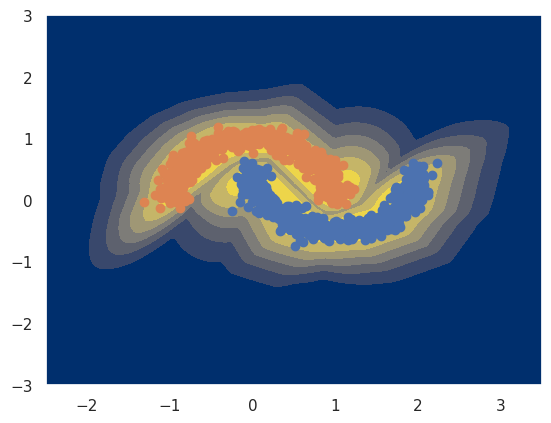

In [11]:
domain = 3
x_lin = np.linspace(-domain+0.5, domain+0.5, 100)
y_lin = np.linspace(-domain, domain, 100)

xx, yy = np.meshgrid(x_lin, y_lin)

X_grid = np.column_stack([xx.flatten(), yy.flatten()])

X_vis, y_vis = sklearn.datasets.make_moons(n_samples=1000, noise=noise)
mask = y_vis.astype(np.bool)


with torch.no_grad():
    z, output, embeddings = model(torch.from_numpy(X_grid).float())
    print(embeddings)
    print(z[0])
    confidence = output.max(1)[0].numpy()


z = confidence.reshape(xx.shape)

plt.figure()
plt.contourf(x_lin, y_lin, z, cmap='cividis')

plt.scatter(X_vis[mask,0], X_vis[mask,1])
plt.scatter(X_vis[~mask,0], X_vis[~mask,1])

In [12]:
print(X_grid.shape)

print(str(model))

(10000, 2)
Model_bilinear(
  (fc1): Linear(in_features=2, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=20, bias=True)
)


In [13]:
# output = model(torch.from_numpy(np.array([0,0])).float())[1]

In [14]:
import copy
from torch.quantization import quantize_fx

quantise = True
if quantise:
    dataiter = iter(dl_train)
    images, labels = next(dataiter)

    m = copy.deepcopy(model)
    m.to("cpu")
    m.eval()
    qconfig_dict = {"": torch.quantization.get_default_qconfig("fbgemm")}
    model_prepared = quantize_fx.prepare_fx(m, qconfig_dict, images)

    with torch.inference_mode():
        for _ in range(10):
            images, labels = next(dataiter)
            model_prepared(images)
    model_quantized = quantize_fx.convert_fx(model_prepared)
    


In [15]:
print(model_quantized)

GraphModule(
  (fc1): QuantizedLinearReLU(in_features=2, out_features=20, scale=0.013372106477618217, zero_point=0, qscheme=torch.per_channel_affine)
  (fc2): QuantizedLinearReLU(in_features=20, out_features=20, scale=0.006554891355335712, zero_point=0, qscheme=torch.per_channel_affine)
  (fc3): QuantizedLinear(in_features=20, out_features=20, scale=0.017166415229439735, zero_point=75, qscheme=torch.per_channel_affine)
)



def forward(self, x):
    fc1_input_scale_0 = self.fc1_input_scale_0
    fc1_input_zero_point_0 = self.fc1_input_zero_point_0
    quantize_per_tensor = torch.quantize_per_tensor(x, fc1_input_scale_0, fc1_input_zero_point_0, torch.quint8);  x = fc1_input_scale_0 = fc1_input_zero_point_0 = None
    fc1 = self.fc1(quantize_per_tensor);  quantize_per_tensor = None
    fc2 = self.fc2(fc1);  fc1 = None
    fc3 = self.fc3(fc2);  fc2 = None
    dequantize_3 = fc3.dequantize();  fc3 = None
    w = self.W
    einsum = torch.functional.einsum('ij,mnj->imn', dequantize_3, w);  

In [16]:
model_quantized.print_readable()

class GraphModule(torch.nn.Module):
    def forward(self, x):
        
        # No stacktrace found for following nodes 
        fc1_input_scale_0 = self.fc1_input_scale_0
        fc1_input_zero_point_0 = self.fc1_input_zero_point_0
        quantize_per_tensor = torch.quantize_per_tensor(x, fc1_input_scale_0, fc1_input_zero_point_0, torch.quint8);  x = fc1_input_scale_0 = fc1_input_zero_point_0 = None
        
        # File: /opt/conda/lib/python3.10/site-packages/torch/ao/quantization/fx/tracer.py:103, code: return super().call_module(m, forward, args, kwargs)
        fc1 = self.fc1(quantize_per_tensor);  quantize_per_tensor = None
        
        # File: /opt/conda/lib/python3.10/site-packages/torch/ao/quantization/fx/tracer.py:103, code: return super().call_module(m, forward, args, kwargs)
        fc2 = self.fc2(fc1);  fc1 = None
        
        # File: /opt/conda/lib/python3.10/site-packages/torch/ao/quantization/fx/tracer.py:103, code: return super().call_module(m, forward, ar

tensor([[ 0.7177, -1.9697],
        [ 1.7670, -2.5150],
        [-1.5313, -0.1789],
        [-1.4696,  1.3007],
        [ 0.4158, -1.1463],
        [-0.1471, -1.0010],
        [ 0.7710,  1.7244],
        [ 1.0631, -0.0847],
        [-0.8783, -2.3811],
        [ 1.4062,  0.5604]])
tensor([[ 2.8102, -2.6897],
        [ 0.9320, -2.4879],
        [-0.6478, -1.3172],
        [-1.7573,  2.8871],
        [ 0.5450, -1.3843],
        [-0.0307, -0.6317],
        [-0.2190,  2.8875],
        [ 1.8715, -0.3371],
        [-1.7033, -2.4823],
        [ 1.8355,  0.7404]])


/tmp/ipykernel_1641/2489577463.py:10: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = y_vis.astype(np.bool)


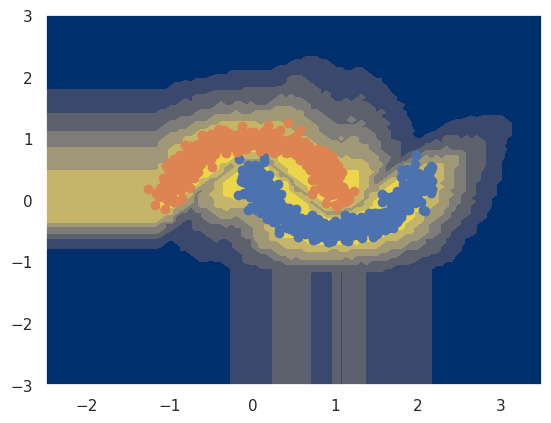

In [17]:
domain = 3
x_lin = np.linspace(-domain+0.5, domain+0.5, 100)
y_lin = np.linspace(-domain, domain, 100)

xx, yy = np.meshgrid(x_lin, y_lin)

X_grid = np.column_stack([xx.flatten(), yy.flatten()])

X_vis, y_vis = sklearn.datasets.make_moons(n_samples=1000, noise=noise)
mask = y_vis.astype(np.bool)

with torch.no_grad():
    z, output, embeddings = model_quantized(torch.from_numpy(X_grid).float())
    print(embeddings)
    print(z[0])
    confidence = output.max(1)[0].numpy()


z = confidence.reshape(xx.shape)

plt.figure()
plt.contourf(x_lin, y_lin, z, cmap='cividis')

plt.scatter(X_vis[mask,0], X_vis[mask,1])
plt.scatter(X_vis[~mask,0], X_vis[~mask,1])

- input t